# Day 15: 不平衡数据集的处理



# 一、数据准备与基线模型

## 1.1 数据预处理

In [1]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('E:\study\PythonStudy\python60-days-challenge-master\data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("E:\study\PythonStudy\python60-days-challenge-master\data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集

## 1.2 基准模型结果

In [2]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的随机森林 ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数随机森林 (训练集 -> 测试集) ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(X_test) # 在测试集上预测


print("\n默认随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数随机森林 (训练集 -> 测试集) ---

默认随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1059
           1       0.79      0.30      0.43       441

    accuracy                           0.77      1500
   macro avg       0.78      0.63      0.64      1500
weighted avg       0.77      0.77      0.73      1500

默认随机森林 在测试集上的混淆矩阵：
[[1023   36]
 [ 309  132]]


# 二、数据层面处理方法

数据层面方法通过调整训练集的类别分布来缓解不平衡问题。所有方法都使用**相同的测试集**进行评估，确保公平对比。

## 2.1 过采样方法
- 过采样一般包含2种做法：随机采样和SMOTE
- 过采样是把少的类别补充和多的类别一样多，欠采样是把多的类别减少和少的类别一样
- 一般都是缺数据，所以很少用欠采样

### 2.1.1 随机过采样ROS

随机过采样是从少数类中随机选择样本，并将其复制后添加到训练集。
随机过采样的步骤如下：

1. 确定少数类的样本数。
2. 从少数类中随机选择样本，并将其复制。
3. 将复制的样本添加到训练集。

随机过采样的优点是，它可以增加少数类的样本数，从而提高模型的泛化能力。小。

随机过采样的缺点是，它可能会增加训练集的大小，从而增加训练时间。此外，它可能会增加噪声，并且可能会增加模型的偏差。


做难题，复制n份，不如做新的题目。

In [3]:
# 需要安装imbalanced-learn库
# 这个库是专门用于处理不平衡数据集的，提供了多种重采样方法
# !pip install -U imbalanced-learn 

In [4]:
## --- 2. 随机过采样 (Random Oversampling) ---
print("\n--- 2. 随机过采样 (Random Oversampling) ---")
# 导入随机过采样器
from imblearn.over_sampling import RandomOverSampler
import time

# 实例化随机过采样器，设置 sampling_strategy='minority' 表示只对少数类进行采样
# random_state 用于确保结果可复现
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

# 对训练集进行过采样。注意：只对训练集进行操作，测试集保持不变
start_time = time.time()
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
end_time = time.time()
print(f"随机过采样耗时: {end_time - start_time:.4f} 秒")

# 检查采样后的类别分布
print("\n随机过采样后训练集类别分布:")
print(pd.Series(y_resampled_ros).value_counts())

# 使用过采样后的数据训练随机森林模型
rf_model_ros = RandomForestClassifier(random_state=42)
rf_model_ros.fit(X_resampled_ros, y_resampled_ros) # 在过采样后的训练集上训练
rf_pred_ros = rf_model_ros.predict(X_test) # 在原始测试集上预测

print("\n随机过采样后模型 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred_ros))
print("随机过采样后模型 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred_ros))


--- 2. 随机过采样 (Random Oversampling) ---
随机过采样耗时: 0.0060 秒

随机过采样后训练集类别分布:
Credit Default
0    4328
1    4328
Name: count, dtype: int64

随机过采样后模型 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1059
           1       0.67      0.34      0.46       441

    accuracy                           0.76      1500
   macro avg       0.72      0.64      0.65      1500
weighted avg       0.74      0.76      0.73      1500

随机过采样后模型 在测试集上的混淆矩阵：
[[985  74]
 [289 152]]


### 2.2 smote过采样

smote过采样是合成样本的方法。


1. 对于少数类中的每个样本，计算它与少数类中其他样本的距离，得到其$k$近邻（一般$k$取5或其他合适的值）。
2. 从$k$近邻中随机选择一个样本。
3. 计算选定的近邻样本与原始样本之间的差值。
4. 生成一个在0到1之间的随机数。
5. 将差值乘以随机数，然后加到原始样本上，得到一个新的合成样本。
6. 重复上述步骤，直到合成出足够数量的少数类样本，使得少数类和多数类样本数量达到某种平衡。
7. 使用过采样后的数据集训练模型并评估模型性能。

SMOTE的核心思想是通过在少数类样本的特征空间中进行插值来合成新的样本



In [12]:
## --- 3. SMOTE 过采样 (Synthetic Minority Over-sampling Technique) ---
print("\n--- 3. SMOTE 过采样 (Synthetic Minority Over-sampling Technique) ---")
# 导入 SMOTE 过采样器
from imblearn.over_sampling import SMOTE

# 实例化 SMOTE 过采样器
smote = SMOTE(random_state=42)

# 对训练集进行 SMOTE 过采样
start_time = time.time()
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)
end_time = time.time()
print(f"SMOTE 过采样耗时: {end_time - start_time:.4f} 秒")

# 检查采样后的类别分布
print("\nSMOTE 过采样后训练集类别分布:")
print(pd.Series(y_resampled_smote).value_counts())

# 使用 SMOTE 过采样后的数据训练随机森林模型
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_resampled_smote, y_resampled_smote) # 在过采样后的训练集上训练
rf_pred_smote = rf_model_smote.predict(X_test) # 在原始测试集上预测

print("\nSMOTE 过采样后模型 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred_smote))
print("SMOTE 过采样后模型 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred_smote))


--- 3. SMOTE 过采样 (Synthetic Minority Over-sampling Technique) ---
SMOTE 过采样耗时: 0.0711 秒

SMOTE 过采样后训练集类别分布:
Credit Default
0    4328
1    4328
Name: count, dtype: int64

SMOTE 过采样后模型 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1059
           1       0.64      0.35      0.45       441

    accuracy                           0.75      1500
   macro avg       0.70      0.63      0.64      1500
weighted avg       0.73      0.75      0.72      1500

SMOTE 过采样后模型 在测试集上的混淆矩阵：
[[972  87]
 [288 153]]


## 2.2 欠采样方法

### 2.2.1 随机欠采样

随机删除多数类样本。可能丢失重要信息。

In [13]:
## --- 6. 欠采样：随机欠采样 (Random Under-Sampling) ---
print("\n--- 6. 欠采样：随机欠采样 (Random Under-Sampling) ---")
# 导入随机欠采样器
from imblearn.under_sampling import RandomUnderSampler

# 实例化随机欠采样器，sampling_strategy='majority' 表示只对多数类进行采样
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# 对训练集进行欠采样
start_time = time.time()
# X_resampled_rus 和 y_resampled_rus 是欠采样后的训练集
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
end_time = time.time()
print(f"随机欠采样耗时: {end_time - start_time:.4f} 秒")

# 检查采样后的类别分布
print("\n随机欠采样后训练集类别分布:")
# 欠采样后，多数类样本数量将等于少数类样本数量
print(pd.Series(y_resampled_rus).value_counts())

# 使用欠采样后的数据训练随机森林模型
rf_model_rus = RandomForestClassifier(random_state=42)
rf_model_rus.fit(X_resampled_rus, y_resampled_rus)
rf_pred_rus = rf_model_rus.predict(X_test) # 在原始测试集上预测

print("\n随机欠采样后模型 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred_rus))
print(confusion_matrix(y_test, rf_pred_rus))


--- 6. 欠采样：随机欠采样 (Random Under-Sampling) ---
随机欠采样耗时: 0.0055 秒

随机欠采样后训练集类别分布:
Credit Default
0    1672
1    1672
Name: count, dtype: int64

随机欠采样后模型 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1059
           1       0.45      0.63      0.52       441

    accuracy                           0.66      1500
   macro avg       0.63      0.65      0.63      1500
weighted avg       0.70      0.66      0.67      1500

[[715 344]
 [165 276]]


随机欠采样可能会大幅提高少数类的召回率 (Recall)，但可能会因为丢失了太多多数类信息而导致整体准确率 (Accuracy)下降

### 2.2.2 ENN

ENN 是一种基于近邻的欠采样技术，它的核心思想不是为了平衡数据集，而是作为一种数据清洁（Data Cleaning）或噪声移除的手段。ENN 的作用是清洗训练集中的噪声和边界模糊的多数类样本，从而减少模型对这些模糊区域的学习，专注于更明确的类别特征。

核心思想：
1. 识别“坏”样本： ENN 遍历数据集中的每一个多数类样本。
2. 近邻判断： 对于某个多数类样本 $x$，它检查 $x$ 的 $K$ 个最近邻居（通常 $K=3$）。
3. 移除原则： 如果 $x$ 的多数邻居数量少于其所有 $K$ 个邻居中的一半（即，如果 $x$ 被它的邻居误分类了），那么 $x$ 就会被认为是噪声或边界模糊的样本，并被移除。

简单来说：ENN 删除了那些与自身类别不一致的多数类样本。这样做的目的是平滑分类边界，使多数类和少数类之间的界限更加清晰，有助于后续训练的模型（如随机森林）做出更准确的决策。

In [14]:
## --- 7. 欠采样：Edited Nearest Neighbors (ENN) ---
print("\n--- 7. 欠采样：Edited Nearest Neighbors (ENN) ---")
from imblearn.under_sampling import EditedNearestNeighbours

# 实例化 ENN (默认参数通常用于清理多数类样本)
# sampling_strategy='all' 表示对所有类别应用规则，但实际主要移除多数类中的噪声
enn = EditedNearestNeighbours(sampling_strategy='all', n_neighbors=3, kind_sel='all')

# 对训练集进行 ENN 欠采样（数据清洗）
start_time = time.time()
X_resampled_enn, y_resampled_enn = enn.fit_resample(X_train, y_train)
end_time = time.time()
print(f"ENN 欠采样耗时: {end_time - start_time:.4f} 秒")

# 检查采样后的类别分布
print("\nENN 欠采样后训练集类别分布:")
# 注意：ENN 是数据清洗，不会完全平衡数据集，多数类样本会减少，但仍多于少数类
print(pd.Series(y_resampled_enn).value_counts())

# 使用 ENN 欠采样后的数据训练随机森林模型
rf_model_enn = RandomForestClassifier(random_state=42)
rf_model_enn.fit(X_resampled_enn, y_resampled_enn)
rf_pred_enn = rf_model_enn.predict(X_test)

print("\nENN 欠采样后模型 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred_enn))
print(confusion_matrix(y_test, rf_pred_enn))


--- 7. 欠采样：Edited Nearest Neighbors (ENN) ---
ENN 欠采样耗时: 0.0472 秒

ENN 欠采样后训练集类别分布:
Credit Default
0    1991
1      60
Name: count, dtype: int64

ENN 欠采样后模型 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1059
           1       1.00      0.14      0.25       441

    accuracy                           0.75      1500
   macro avg       0.87      0.57      0.55      1500
weighted avg       0.81      0.75      0.67      1500

[[1059    0]
 [ 379   62]]


ENN 的目标是清洗，它对少数类召回率的提升可能不如随机欠采样明显，但它通常能提供更稳健的性能提升，特别是当数据中存在大量噪声时。

## 2.3 混合采样

混合采样结合了过采样和欠采样的优点，旨在：
1. 增加少数类的代表性（通过合成样本）。
2. 清理/删除多数类的噪声和冗余样本。

SMOTE + ENN 是最经典、最有效的混合采样组合之一，因为它结合了：
1. SMOTE：在少数类周围生成新的合成样本，解决样本数量不足的问题。
2. ENN：随后应用 ENN 规则来清理数据集，移除那些位于分类边界上的模糊样本（包括 SMOTE 生成的样本和原始多数类样本），使分类边界更加清晰。


In [8]:
## --- 8. 混合采样：SMOTE + ENN (SMOTENN) ---
print("\n--- 8. 混合采样：SMOTE + ENN (SMOTENN) ---")
# 导入 SMOTENN
from imblearn.combine import SMOTEENN

# 实例化 SMOTEENN，它内部集成了 SMOTE 和 ENN
# random_state 用于确保结果可复现
smote_enn = SMOTEENN(random_state=42)

# 对训练集进行混合采样
start_time = time.time()
# X_resampled_smotenn 和 y_resampled_smotenn 是混合采样后的训练集
X_resampled_smotenn, y_resampled_smotenn = smote_enn.fit_resample(X_train, y_train)
end_time = time.time()
print(f"SMOTE + ENN 混合采样耗时: {end_time - start_time:.4f} 秒")

# 检查采样后的类别分布
print("\nSMOTE + ENN 混合采样后训练集类别分布:")
# 经过 SMOTE 和 ENN 清理后，数据集通常会接近平衡，但多数类会略有减少
print(pd.Series(y_resampled_smotenn).value_counts())

# 使用混合采样后的数据训练随机森林模型
rf_model_smotenn = RandomForestClassifier(random_state=42)
rf_model_smotenn.fit(X_resampled_smotenn, y_resampled_smotenn)
rf_pred_smotenn = rf_model_smotenn.predict(X_test) # 在原始测试集上预测

print("\nSMOTE + ENN 混合采样后模型 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred_smotenn))
print("SMOTE + ENN 混合采样后模型 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred_smotenn))


--- 8. 混合采样：SMOTE + ENN (SMOTENN) ---
SMOTE + ENN 混合采样耗时: 0.0705 秒

SMOTE + ENN 混合采样后训练集类别分布:
Credit Default
1    2531
0    1770
Name: count, dtype: int64

SMOTE + ENN 混合采样后模型 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.83      0.66      0.73      1059
           1       0.45      0.67      0.53       441

    accuracy                           0.66      1500
   macro avg       0.64      0.66      0.63      1500
weighted avg       0.71      0.66      0.67      1500

SMOTE + ENN 混合采样后模型 在测试集上的混淆矩阵：
[[694 365]
 [147 294]]


采样后结果并没有变好，可能是：
1. 没有调整超参数
2. 删除了太多有效样本
3. 该方法不适合该数据

# 三、 算法层面

不改变数据，而是调整模型训练过程或使用对不平衡数据鲁棒的算法。

在 `RandomForestClassifier` 中应用 (`class_weight` 参数)

Scikit-learn 中的 `RandomForestClassifier` 提供了 `class_weight` 参数来实现代价敏感学习：

1.  **`class_weight=None` (默认值):**
    *   所有类别被赋予**相同的权重 (1)**。
    *   算法在构建树和计算分裂标准（如基尼不纯度）时，**不区分**多数类和少数类。
    *   在不平衡数据上，这自然导致模型**偏向多数类**。

2.  **`class_weight='balanced'`:**
    *   算法**自动**根据训练数据 `y` 中各类别的频率来调整权重。
    *   权重计算方式与类别频率成**反比**：`weight = n_samples / (n_classes * np.bincount(y))`。
    *   这意味着**少数类样本获得更高的权重**，多数类样本获得较低的权重。
    *   目的是在训练中“放大”少数类的重要性，促使模型提升对少数类的识别能力。

3.  **`class_weight={dict}` (手动设置):**
    *   可以提供一个字典，手动为每个类别标签指定权重，例如 `class_weight={0: 1, 1: 10}` 表示类别 1 的权重是类别 0 的 10 倍。

*   **优点：**
    *   从模型学习的根本上解决问题。
    *   可能得到泛化能力更强的模型。
    *   许多常用算法内置支持，实现方便。
*   **注意：** 使用 `class_weight` 时，推荐结合**交叉验证**（特别是 `StratifiedKFold`）来可靠地评估其效果和模型的稳定性。

In [9]:
print("\n--- 代价敏感学习：设置 class_weight='balanced' ---")
# 使用原始训练集 X_train, y_train

# 检查原始训练集类别分布 (多数类: 0, 少数类: 1)
print("原始训练集类别分布:")
print(y_train.value_counts())

start_time = time.time()
# 实例化随机森林，设置 class_weight='balanced'
rf_model_weighted = RandomForestClassifier(
    random_state=42,
    class_weight='balanced' # 核心参数：根据类别频率自动调整权重
)
rf_model_weighted.fit(X_train, y_train) # 在原始训练集上训练
rf_pred_weighted = rf_model_weighted.predict(X_test) # 在测试集上预测
end_time = time.time()

print(f"权重调整模型训练与预测耗时: {end_time - start_time:.4f} 秒")

print("\n权重调整随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred_weighted))
print("权重调整随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred_weighted))


--- 代价敏感学习：设置 class_weight='balanced' ---
原始训练集类别分布:
Credit Default
0    4328
1    1672
Name: count, dtype: int64
权重调整模型训练与预测耗时: 0.7708 秒

权重调整随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.76      0.97      0.86      1059
           1       0.81      0.27      0.41       441

    accuracy                           0.77      1500
   macro avg       0.78      0.62      0.63      1500
weighted avg       0.78      0.77      0.72      1500

权重调整随机森林 在测试集上的混淆矩阵：
[[1030   29]
 [ 320  121]]


# 四、评估指标层面

修改分类阈值

这种方法在模型**训练完成之后**介入，通过调整最终分类的决策规则来平衡不同类型的错误。

*   **核心思想：** 改变将模型输出的概率（或得分）映射到最终类别标签的门槛。
*   **作用机制：** 模型通常输出一个样本属于正类（通常设为少数类）的概率 `p`。默认情况下，如果 `p > 0.5`，则预测为正类。修改阈值意味着改变这个 `0.5`，例如，如果要求更高的召回率，可以将阈值降低（如 `p > 0.3` 就预测为正类）。
*   **目的：** 在**不改变已训练好的模型**的情况下，根据业务需求调整精确率（Precision）和召回率（Recall）之间的权衡。通常用于**提高少数类的召回率**（但可能会牺牲精确率）。
*   **影响：** **不改变**模型学到的参数或决策边界本身，只改变如何**解释**模型的输出。
*   **优点：**
    *   实现简单，无需重新训练模型。
    *   非常直观，可以直接在 PR 曲线或 ROC 曲线上选择操作点。
    *   适用于任何输出概率或分数的模型。
*   **缺点：**
    *   治标不治本。如果模型本身就没学好如何区分少数类（概率输出普遍很低），单纯降低阈值可能效果有限或导致大量误报（低精确率）。

核心差异总结

| 特性         | 修改类别权重 (`class_weight`)                  | 修改分类阈值                         |
| :----------- | :--------------------------------------------- | :----------------------------------- |
| **作用阶段** | 模型**训练**时                                 | 模型**预测**（或评估）时             |
| **作用对象** | 模型的**损失函数**、**参数学习**过程             | 模型输出概率/分数到最终预测的**决策规则** |
| **对模型影响** | **改变**学习到的模型本身和决策边界               | **不改变**已学习到的模型             |
| **性质**     | **根本性**调整，代价敏感学习                   | **后处理**性质的调整                 |
| **目标侧重** | 学习一个内在区分能力更强的模型                 | 在现有模型上调整性能指标的权衡       |
| **实现方式** | 设置算法的参数（如 `class_weight='balanced'`） | 在预测后应用不同的概率门槛           |

实践建议

1.  **评估指标先行：** 明确你的目标，使用适合不平衡数据的指标（Recall, F1-Score, AUC-PR, Balanced Accuracy, MCC）来评估模型。
2.  **优先尝试根本方法：** 通常建议首先尝试**修改权重 (`class_weight='balanced'`)** 或 **数据采样方法 (如 SMOTE)**，因为它们试图从源头改善模型学习。
3.  **交叉验证评估：** 在使用 `class_weight` 或采样方法时，务必使用**分层交叉验证 (Stratified K-Fold)** 来获得对模型性能的可靠估计。
4.  **阈值调整作为补充：** 修改阈值可以作为一种**补充手段**或**最后的微调**。即使使用了权重调整，有时仍需根据具体的业务需求（如必须达到某个召回率水平）来调整阈值，找到最佳的操作点。
5.  **组合策略：** 有时结合多种方法（如 SMOTE + `class_weight`）可能会产生更好的结果。

总之，修改权重旨在训练一个“更好”的模型，而修改阈值是在一个“已有”模型上调整其表现。理解它们的差异有助于你选择更合适的策略来应对不平衡数据集的挑战。


In [10]:
print("\n--- 阈值调整：计算概率并寻找 F1-Score 最佳阈值 ---")
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
import numpy as np # 确保导入 numpy

# 1. 确保我们使用的是基准模型 (rf_model) 在测试集上的概率预测
y_proba = rf_model.predict_proba(X_test)[:, 1] # 获取类别 1 的预测概率

# 2. 计算所有可能的精确率、召回率和对应的阈值
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# 3. 计算所有阈值对应的 F1-Score
# 注意：fscores 比 thresholds 多一个值，因此在计算 ix 时只看 thresholds 的范围
fscores = (2 * precisions * recalls) / (precisions + recalls)

# 4. 找到 F1-Score 最大的索引 (ix)
# np.argmax 返回最大值的索引。我们使用 [:-1] 来匹配 thresholds 的长度
ix = np.argmax(fscores[:-1])
best_threshold = thresholds[ix]
best_fscore = fscores[ix]

# 5. 打印找到的最佳阈值和性能
print(f"最佳 F1-Score 对应的阈值: {best_threshold:.4f}")
print(f"该阈值下的最大 F1-Score (类别 1): {best_fscore:.4f}")
print(f"该阈值下的精确率 (类别 1): {precisions[ix]:.4f}")
print(f"该阈值下的召回率 (类别 1): {recalls[ix]:.4f}")

# 6. 使用最佳阈值生成最终预测结果
y_pred_best_threshold = (y_proba >= best_threshold).astype(int)

# 7. 打印最终评估报告
print(f"\n基准模型，使用最佳 F1 阈值 ({best_threshold:.4f}) 时的分类报告：")
print(classification_report(y_test, y_pred_best_threshold))
print("该阈值下的混淆矩阵：")
print(confusion_matrix(y_test, y_pred_best_threshold))


--- 阈值调整：计算概率并寻找 F1-Score 最佳阈值 ---
最佳 F1-Score 对应的阈值: 0.2500
该阈值下的最大 F1-Score (类别 1): 0.5514
该阈值下的精确率 (类别 1): 0.4328
该阈值下的召回率 (类别 1): 0.7596

基准模型，使用最佳 F1 阈值 (0.2500) 时的分类报告：
              precision    recall  f1-score   support

           0       0.85      0.59      0.69      1059
           1       0.43      0.76      0.55       441

    accuracy                           0.64      1500
   macro avg       0.64      0.67      0.62      1500
weighted avg       0.73      0.64      0.65      1500

该阈值下的混淆矩阵：
[[620 439]
 [106 335]]



--- 可视化不同阈值下的 F1-Score 变化 ---


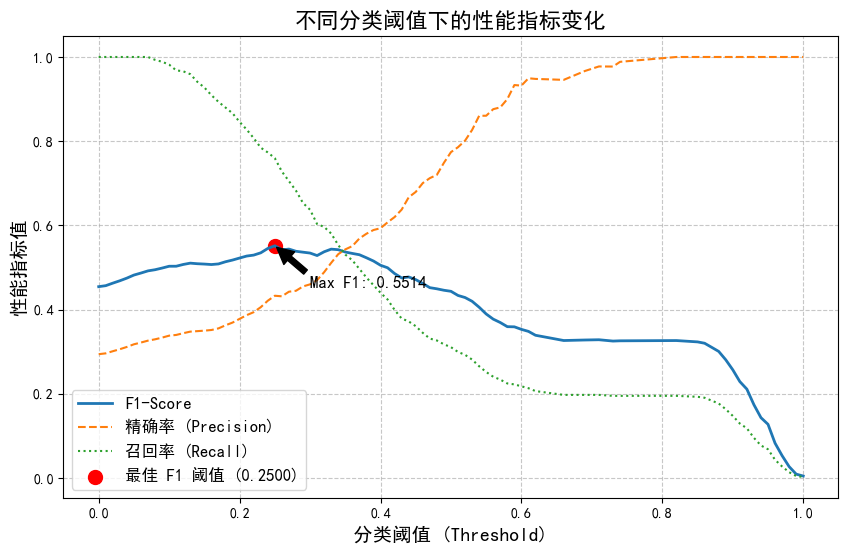

In [11]:
print("\n--- 可视化不同阈值下的 F1-Score 变化 ---")

# 1. 绘制 F1-Score 随阈值变化的曲线
plt.figure(figsize=(10, 6))
# thresholds 比 fscores 少一个点，我们使用 fscores[:-1] 匹配
plt.plot(thresholds, fscores[:-1], label='F1-Score', linewidth=2)
# 绘制精确率和召回率，供参考
plt.plot(thresholds, precisions[:-1], label='精确率 (Precision)', linestyle='--')
plt.plot(thresholds, recalls[:-1], label='召回率 (Recall)', linestyle=':')

# 2. 标记 F1-Score 的最佳点
# best_threshold 和 best_fscore 来自上一步骤的计算结果
plt.scatter(best_threshold, best_fscore, marker='o', color='red', s=100,
            label=f'最佳 F1 阈值 ({best_threshold:.4f})')
plt.annotate(f'Max F1: {best_fscore:.4f}',
             xy=(best_threshold, best_fscore),
             xytext=(best_threshold + 0.05, best_fscore - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

# 3. 设置图表属性
plt.title('不同分类阈值下的性能指标变化', fontsize=16)
plt.xlabel('分类阈值 (Threshold)', fontsize=14)
plt.ylabel('性能指标值', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# 为了演示步长细致的效果，我们不再手动取步长，
# 因为 precision_recall_curve 已经计算了所有数据点对应的阈值。
# 如果想看特定范围的F1变化，可以只绘制该范围的曲线。

1. F1-Score 曲线的最高点： 这就是我们选择的最佳阈值，它平衡了精确率和召回率。
2. 精确率-召回率的消长关系：
    - 当阈值很低时（靠近 0），模型将大量样本预测为 1，此时召回率高（不错过任何 1），但精确率低（有很多误判）。
    - 当阈值很高时（靠近 1），模型只对那些极有把握的样本预测为 1，此时精确率高，但召回率低（错过了大量 1）。
3. 如何根据业务需求选择： 如果业务更看重避免误报（精确率），则应将阈值向右（大于 $0.5$）移动；如果更看重不错过任何少数类（召回率），则应将阈值向左（小于 $0.5$）移动。